In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
sns.set()
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import statsmodels.api as sm
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import train_test_split

import warnings
# import the_module_that_warns

warnings.filterwarnings("ignore")

from fbprophet import Prophet

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning:

The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.



## Load the datasets

In [2]:
# Input data files are available in the "../input/" directory.
# First let us load the datasets into different Dataframes



# Input data files are available in the "../input/" directory.
# First let us load the datasets into different Dataframes
def load_data(datapath):
    data = pd.read_csv(datapath)
   # Dimensions
    print('Shape:', data.shape)
    # Set of features we have are: date, store, and item
    display(data.sample(10))
    return data
    



    
train_df = load_data('../input/traindata.csv')
test_df = load_data('../input/testdata.csv')
sample_df = load_data('../input/sampledata.csv')


Shape: (913000, 4)


,date,store,item,sales
266009,5/24/2016,1,15,74
847531,9/25/2013,1,47,5
107200,7/16/2016,1,6,91
464541,1/8/2015,1,26,24
518362,5/24/2017,1,29,91
372805,10/29/2013,1,21,24
814847,3/28/2014,1,45,62
584679,12/26/2013,1,33,46
72492,7/2/2016,1,4,27
621659,3/31/2015,1,35,50


Shape: (45000, 4)


,id,date,store,item
31860,31860,1/1/2018,1,36
9785,9785,3/7/2018,1,11
10065,10065,3/17/2018,1,12
42838,42838,3/30/2018,1,48
17084,17084,3/16/2018,1,19
20025,20025,2/15/2018,1,23
17515,17515,2/25/2018,1,20
10639,10639,1/20/2018,1,12
28819,28819,1/20/2018,1,33
10193,10193,1/24/2018,1,12


Shape: (45000, 2)


,id,sales
1182,1182,52
31420,31420,52
37362,37362,52
8611,8611,52
7351,7351,52
28725,28725,52
26111,26111,52
40340,40340,52
9147,9147,52
19867,19867,52


# Time series data exploration

The goal of this kernel is data exploration of a time-series sales data of store items.   
The tools `pandas`, `matplotlib`  and, `plotly`  are used for slicing & dicing the data and visualizations.


## Distribution of sales
How the sales varies across all the items in all the stores

In [3]:
# Sales distribution across the train data
def sales_dist(data):
    """
        Sales_dist used for Checing Sales Distribution.
        data :  contain data frame which contain sales data
    """
    sales_df = data.copy(deep=True)
    sales_df['sales_bins'] = pd.cut(sales_df.sales, [0, 50, 100, 150, 200, 250])
    print('Max sale:', sales_df.sales.max())
    print('Min sale:', sales_df.sales.min())
    print('Avg sale:', sales_df.sales.mean())
    print()
    return sales_df

sales_df = sales_dist(train_df)

# Total number of data points
total_points = pd.value_counts(sales_df.sales_bins).sum()
print('Sales bucket v/s Total percentage:')
display(pd.value_counts(sales_df.sales_bins).apply(lambda s: (s/total_points)*100))

Max sale: 231
Min sale: 0
Avg sale: 52.250286966046005

Sales bucket v/s Total percentage:


(0, 50]       54.591407
(50, 100]     38.388322
(100, 150]     6.709974
(150, 200]     0.308544
(200, 250]     0.001752
Name: sales_bins, dtype: float64

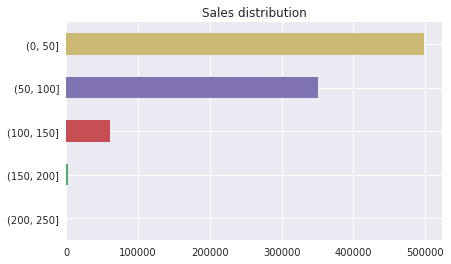

In [4]:
# Let us visualize the same
sales_count = pd.value_counts(sales_df.sales_bins)
sales_count.sort_values(ascending=True).plot(kind='barh', title='Sales distribution', );
# sns.countplot(sales_count)

As we can see, almost 92% of sales are less than 100. Max, min and average sales are 231, 0 and 52.25 respectively.   
So any prediction model has to deal with the skewness in the data appropriately. 

## How does sales vary across stores
Let us get a overview of sales distribution in the whole data.
We have just one store location for now

sales                                                         \
item          1          2          3          4          5          6    
store                                                                     
1      21.981599  58.574151  36.642223  22.010241  18.358708  58.503888   

                                                     ...                 \
item          7          8          9          10    ...             41   
store                                                ...                  
1      58.531051  76.950055  51.389869  73.227437    ...      22.002136   

                                                                         \
item          42         43         44         45         46         47   
store                                                                     
1      36.688116  51.294359  29.398193  80.584173  58.639869  22.003341   

                                        
item          48         49         50  
store                                   
1      51.352848  29.335323  65.882202  

[1 rows x 50 columns]

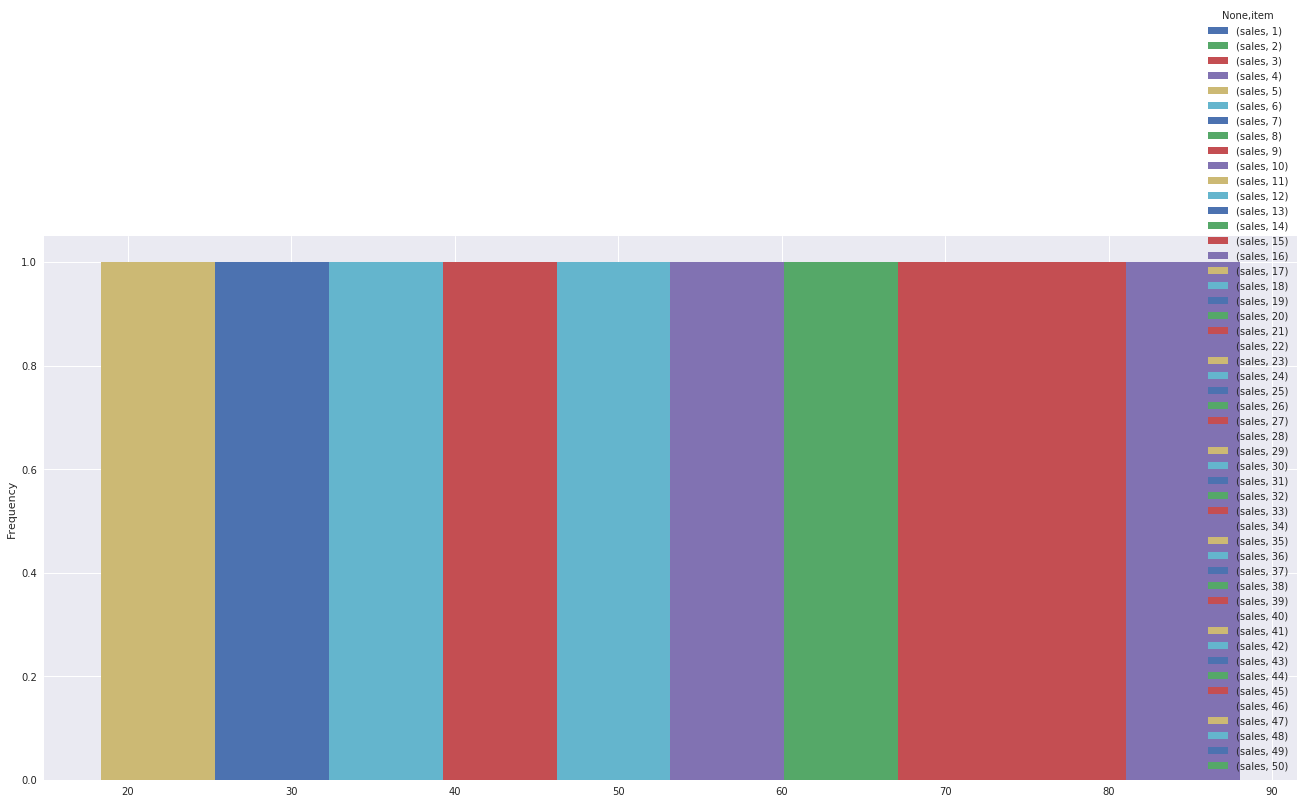

In [5]:
# Let us understand the sales data distribution across the stores
def sales_data_understanding(data):    
    store_df = data.copy()
    plt.figure(figsize=(20,10))
    sales_pivoted_df = pd.pivot_table(store_df, index='store', values=['sales','date'], columns='item', aggfunc=np.mean)
    sales_pivoted_df.plot(kind="hist",figsize=(20,10))
    # Pivoted dataframe
    display(sales_pivoted_df)
    return (store_df,sales_pivoted_df)

store_df,sales_pivoted_df = sales_data_understanding(train_df)

This pivoted dataframe has average sales per each store per each item.  
Let use this dataframe and produce some interesting visualizations!

In [6]:
# Let us calculate the average sales of all the items by each store
sales_across_store_df = sales_pivoted_df.copy()
sales_across_store_df['avg_sale'] = sales_across_store_df.apply(lambda r: r.mean(), axis=1)

In [7]:
# Scatter plot of average sales per store
sales_store_data = go.Scatter(
    y = sales_across_store_df.avg_sale.values,
    mode='markers',
    marker=dict(
        size = sales_across_store_df.avg_sale.values,
        color = sales_across_store_df.avg_sale.values,
        colorscale='Viridis',
        showscale=True
    ),
    text = sales_across_store_df.index.values
)
data = [sales_store_data]

sales_store_layout = go.Layout(
    autosize= True,
    title= 'Scatter plot of avg sales per store',
    hovermode= 'closest',
    xaxis= dict(
        title= 'Stores',
        ticklen= 10,
        zeroline= False,
        gridwidth= 1,
    ),
    yaxis=dict(
        title= 'Avg Sales',
        ticklen= 10,
        zeroline= False,
        gridwidth= 1,
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=sales_store_layout)
py.iplot(fig,filename='scatter_sales_store')



## How does sales vary across items

In [8]:
def sales_insight(sales_pivoted_df):
    # Let us calculate the average sales of each of the item across all the stores
    sales_across_item_df = sales_pivoted_df.copy()
    # Aggregate the sales per item and add it as a new row in the same dataframe
    sales_across_item_df.loc[11] = sales_across_item_df.apply(lambda r: r.mean(), axis=0)
    # Note the 11th index row, which is the average sale of each of the item across all the stores
    #display(sales_across_item_df.loc[11:])
    avg_sales_per_item_across_stores_df = pd.DataFrame(data=[[i+1,a] for i,a in enumerate(sales_across_item_df.loc[11:].values[0])], columns=['item', 'avg_sale'])
    # And finally, sort by avg sale
    avg_sales_per_item_across_stores_df.sort_values(by='avg_sale', ascending=False, inplace=True)
    # Display the top 10 rows
    display(avg_sales_per_item_across_stores_df.head())
    return (sales_across_item_df,avg_sales_per_item_across_stores_df)

sales_across_item_df,avg_sales_per_item_across_stores_df = sales_insight(sales_pivoted_df)

,item,avg_sale
14,15,88.030778
27,28,87.881325
12,13,84.316594
17,18,84.275794
24,25,80.686418


Let us visualize these average sales per item!

In [9]:
avg_sales_per_item_across_stores_sorted = avg_sales_per_item_across_stores_df.avg_sale.values
# Scatter plot of average sales per item
sales_item_data = go.Bar(
    x=[i for i in range(0, 50)],
    y=avg_sales_per_item_across_stores_sorted,
    marker=dict(
        color=avg_sales_per_item_across_stores_sorted,
        colorscale='Blackbody',
        showscale=True
    ),
    text = avg_sales_per_item_across_stores_df.item.values
)
data = [sales_item_data]

sales_item_layout = go.Layout(
    autosize= True,
    title= 'Scatter plot of avg sales per item',
    hovermode= 'closest',
    xaxis= dict(
        title= 'Items',
        ticklen= 55,
        zeroline= False,
        gridwidth= 1,
    ),
    yaxis=dict(
        title= 'Avg Sales',
        ticklen= 10,
        zeroline= False,
        gridwidth= 1,
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=sales_item_layout)
py.iplot(fig,filename='scatter_sales_item')

The sales is uniformly distributed across all the items.   
Top items with highest average sale are 15, 28, 13, 18 and with least average sales are 5, 1, 41 and so on.

## Time-series visualization of the sales
Let us see how sales of a given item in a given store varies in a span of 5 years.

In [10]:
def Time_visualization(data):
    store_item_df = data.copy()
    # First, let us filterout the required data
    store_id = 10   # Some store
    item_id = 40    # Some item
    print('Before filter:', store_item_df.shape)
    store_item_df = store_item_df[store_item_df.store == store_id]
    store_item_df = store_item_df[store_item_df.item == item_id]
    print('After filter:', store_item_df.shape)
    #display(store_item_df.head())

    # Let us plot this now
    store_item_ts_data = [go.Scatter(
        x=store_item_df.date,
        y=store_item_df.sales)]
    py.iplot(store_item_ts_data)
    return store_item_df

store_item_df = Time_visualization(train_df)

Before filter: (913000, 4)
After filter: (0, 4)


In [11]:
def sales_monthly(data):
    multi_store_item_df = data.copy()
    # First, let us filterout the required data
    store_ids = [1, 1, 1, 1]   # Some stores
    item_ids = [10, 20, 30, 40]    # Some items
    print('Before filter:', multi_store_item_df.shape)
    multi_store_item_df = multi_store_item_df[multi_store_item_df.store.isin(store_ids)]
    multi_store_item_df = multi_store_item_df[multi_store_item_df.item.isin(item_ids)]
    print('After filter:', multi_store_item_df.shape)
    #display(multi_store_item_df)
    # TODO Monthly avg sales

    # Let us plot this now
    multi_store_item_ts_data = []
    for st,it in zip(store_ids, item_ids):
        flt = multi_store_item_df[multi_store_item_df.store == st]
        flt = flt[flt.item == it]
        multi_store_item_ts_data.append(go.Scatter(x=flt.date, y=flt.sales, name = "Store:" + str(st) + ",Item:" + str(it)))
    py.iplot(multi_store_item_ts_data)
    return (multi_store_item_df)

multi_store_item_df = sales_monthly(train_df)

Before filter: (913000, 4)
After filter: (73040, 4)


# ARIMA

ARIMA is Autoregressive Integrated Moving Average Model, which is a component of SARIMAX, i.e. Seasonal ARIMA with eXogenous regressors.


# LIGHTGBM

In [12]:
def split_data(train_data,test_data):
    train_data['date'] = pd.to_datetime(train_data['date'])
    test_data['date'] = pd.to_datetime(test_data['date'])

    train_data['month'] = train_data['date'].dt.month
    train_data['day'] = train_data['date'].dt.dayofweek
    train_data['year'] = train_data['date'].dt.year

    test_data['month'] = test_data['date'].dt.month
    test_data['day'] = test_data['date'].dt.dayofweek
    test_data['year'] = test_data['date'].dt.year

    col = [i for i in test_data.columns if i not in ['date','id']]
    y = 'sales'
    train_x, test_x, train_y, test_y = train_test_split(train_data[col],train_data[y], test_size=0.2, random_state=2018)
    return (train_x, test_x, train_y, test_y,col)

train_x, test_x, train_y, test_y,col = split_data(train_df,test_df)

In [13]:
train_x.shape,train_y.shape,test_x.shape

((730400, 5), (730400,), (182600, 5))

In [14]:
# from bayes_opt import BayesianOptimization
# def bayes_parameter_opt_lgb(X, y, init_round=15, opt_round=25, n_folds=5, random_seed=6, n_estimators=10000, learning_rate=0.02, output_process=False):
#     # prepare data
#     train_data = lgb.Dataset(data=X, label=y)
#     # parameters
#     def lgb_eval(num_leaves, feature_fraction, bagging_fraction, max_depth, lambda_l1, lambda_l2, min_split_gain, min_child_weight):
#         params = {'application':'regression_l1','num_iterations': n_estimators, 'learning_rate':learning_rate, 'early_stopping_round':100, 'metric':'auc'}
#         params["num_leaves"] = int(round(num_leaves))
#         params['feature_fraction'] = max(min(feature_fraction, 1), 0)
#         params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
#         params['max_depth'] = int(round(max_depth))
#         params['lambda_l1'] = max(lambda_l1, 0)
#         params['lambda_l2'] = max(lambda_l2, 0)
#         params['min_split_gain'] = min_split_gain
#         params['min_child_weight'] = min_child_weight
#         cv_result = lgb.cv(params, train_data, nfold=n_folds, seed=random_seed, stratified=True, verbose_eval =200, metrics=['auc'])
#         return max(cv_result['auc-mean'])
#     # range 
#     lgbBO = BayesianOptimization(lgb_eval, {'num_leaves': (24, 45),
#                                             'feature_fraction': (0.1, 0.9),
#                                             'bagging_fraction': (0.8, 1),
#                                             'max_depth': (5, 8.99),
#                                             'lambda_l1': (0, 5),
#                                             'lambda_l2': (0, 3),
#                                             'min_split_gain': (0.001, 0.1),
#                                             'min_child_weight': (5, 50)}, random_state=0)
#     # optimize
#     lgbBO.maximize(init_points=init_round, n_iter=opt_round)
    
#     # output optimization process
#     if output_process==True: lgbBO.points_to_csv("bayes_opt_result.csv")
    
#     # return best parameters
#     return lgbBO.res['max']['max_params']

# opt_params = bayes_parameter_opt_lgb(train_x, train_y, init_round=5, opt_round=10, n_folds=3, random_seed=6, n_estimators=100, learning_rate=0.02)

In [15]:
# opt_params

In [16]:
%%time

def model(train_x,train_y,test_x,test_y,col):
    params = {
        'nthread': 10,
         'max_depth': 5,
#         'max_depth': 9,
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'regression_l1',
        'metric': 'mape', # this is abs(a-e)/max(1,a)
#         'num_leaves': 39,
        'num_leaves': 64,
        'learning_rate': 0.2,
       'feature_fraction': 0.9,
#         'feature_fraction': 0.8108472661400657,
#         'bagging_fraction': 0.9837558288375402,
       'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'lambda_l1': 3.097758978478437,
        'lambda_l2': 2.9482537987198496,
#       'lambda_l1': 0.06,
#       'lambda_l2': 0.1,
        'verbose': 1,
        'min_child_weight': 6.996211413900573,
        'min_split_gain': 0.037310344962162616,
        }
    
    lgb_train = lgb.Dataset(train_x,train_y)
    lgb_valid = lgb.Dataset(test_x,test_y)
    model = lgb.train(params, lgb_train, 3000, valid_sets=[lgb_train, lgb_valid],early_stopping_rounds=50, verbose_eval=50)
    y_test = model.predict(test_df[col])
    return y_test,model

CPU times: user 24 µs, sys: 0 ns, total: 24 µs
Wall time: 29.1 µs


In [17]:
%%time
y_test, model = model(train_x,train_y,test_x,test_y,col)

Training until validation scores don't improve for 50 rounds.
[50]	training's mape: 0.249769	valid_1's mape: 0.251022
[100]	training's mape: 0.240403	valid_1's mape: 0.241864
[150]	training's mape: 0.237924	valid_1's mape: 0.239719
[200]	training's mape: 0.236958	valid_1's mape: 0.238887
[250]	training's mape: 0.236422	valid_1's mape: 0.238433
[300]	training's mape: 0.236163	valid_1's mape: 0.238261
[350]	training's mape: 0.236069	valid_1's mape: 0.238265
[400]	training's mape: 0.235854	valid_1's mape: 0.238104
[450]	training's mape: 0.235802	valid_1's mape: 0.238094
Early stopping, best iteration is:
[405]	training's mape: 0.235815	valid_1's mape: 0.23807
CPU times: user 1min 14s, sys: 3.99 s, total: 1min 18s
Wall time: 44.5 s


In [18]:
sample_df['sales'] = y_test
sample_df.to_csv('lgb_bayasian_param.csv', index=False)
sample_df['sales'].head()

0    13.713233
1    15.733033
2    15.666133
3    16.051594
4    17.959922
Name: sales, dtype: float64

In [19]:
test_y


175307     53
723603     22
232275     70
794098     22
901131     98
345977     56
399161     54
643189     76
150284     47
320435     79
137648     83
872447     54
324456    137
797164     24
204257    100
28556      41
350012     74
568466     35
674500     21
102088     53
344885     54
146912     52
440452     68
676895     88
163533     73
408801     30
548430     40
125549     62
592235     56
147981     66
         ... 
282982     18
242633     98
322583     72
864324     64
764810     28
832871     32
478421     12
597001     68
310533     55
56932      29
470156     54
893668     22
897971    127
597759     51
411062     18
752962     31
770036     85
377902     34
847449     15
773178     43
8942       12
697616     32
196433     92
689057    102
331013     54
826109     36
466467     47
516266    108
794333     11
824969     63
Name: sales, Length: 182600, dtype: int64

In [20]:
from sklearn.externals import joblib
joblib.dump(model, 'salesmodel.pkl')

['salesmodel.pkl']

In [21]:
bringmod = joblib.load('salesmodel.pkl')
yy =bringmod.predict(test_x)
test_x

,store,item,month,day,year
175307,1,10,1,5,2013
723603,1,40,5,4,2014
232275,1,13,1,3,2014
794098,1,44,6,5,2017
901131,1,50,7,4,2015
345977,1,19,5,3,2015
399161,1,22,12,2,2015
643189,1,36,3,4,2014
150284,1,9,7,0,2014
320435,1,18,6,4,2015


ValueError: Classification metrics can't handle a mix of multiclass-multioutput and multiclass targets

In [ ]:
def average(df1):
    avg  = df1
    df2 = pd.read_csv("../input/private/sub_val-0.132358565029612.csv")
    avg['sales'] = (df1["sales"]*0.4 + df2["sales"]*0.6)
    return avg

avg = average(sample_df)
avg.to_csv("Submission.csv", index=False)